In [1]:
import pandas as pd
import numpy as np
import email, re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from scipy.stats import multivariate_normal as mvn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from wordcloud import WordCloud, STOPWORDS

###### All data

In [2]:
df = pd.read_csv("emails.csv")

###### partial data

In [2]:
df = pd.read_csv("emails.csv", nrows = 35000)

In [3]:
df.shape

(517401, 2)

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
print(df.loc[1]['message'])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

In [4]:
# create list of email objects
emails = list(map(email.parser.Parser().parsestr,df['message']))

# extract headings such as subject, from, to etc..
headings  = emails[0].keys()

# Goes through each email and grabs info for each key
# doc['From'] grabs who sent email in all emails
for key in headings:
    df[key] = [doc[key] for doc in emails]

In [5]:
##Useful functions
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [6]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data = data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'

In [7]:
# df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)
df

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,user,body_new
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,test successful way to go
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,randy can you send me a schedule of the sala...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,lets shoot for tuesday at
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...,<26807948.1075842029936.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 13:30:11 -0800 (PST)",john.zufferli@enron.com,kori.loibl@enron.com,Trade with John Lavorato,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Loibl, Kori </O=ENRON/OU=NA/CN=RECIPIENTS/CN=K...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,This is a trade with OIL-SPEC-HEDGE-NG (John L...,zufferli-j,this is a trade with oilspechedgeng john lavor...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...,<25835861.1075842029959.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 12:47:48 -0800 (PST)",john.zufferli@enron.com,john.lavorato@enron.com,Gas Hedges,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,,"\ExMerge - Zufferli, John\Sent Items",ZUFFERLI-J,john zufferli 6-26-02.PST,Some of my position is with the Alberta Term b...,zufferli-j,some of my position is with the alberta term b...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...,<28979867.1075842029988.JavaMail.evans@thyme>,"Wed, 28 Nov 2001 07:20:00 -0800 (PST)",john.zufferli@enron.com,dawn.doucet@enron.com,RE: CONFIDENTIAL,1.0,text/plain; charset=us-ascii,7bit,"Zufferli, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Doucet, Dawn </O=ENRON/OU=NA/CN=RECIPIE

In [8]:
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

In [9]:
data = df['body_new']
tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 5000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

/Users/yenshou/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaron,ab,abb,ability,able,abraham,absence,absolutely,abx,...,yo,york,youd,youll,young,youre,youve,zero,zimin,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-means

In [11]:
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

In [12]:
Y_sklearn.shape

(517401, 2)

#### Elbow Methods for K-means

In [ ]:
number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters= n_clusters, max_iter=600, algorithm = 'auto').fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [ ]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = kmeans.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

### GMM

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

In [ ]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(Y_sklearn) 
        labels=gmm.predict(Y_sklearn)
        sil=metrics.silhouette_score(Y_sklearn, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

In [ ]:
plt.figure(figsize = (12,8))
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [16]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=1000, tol=1e-4, init_params='random').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

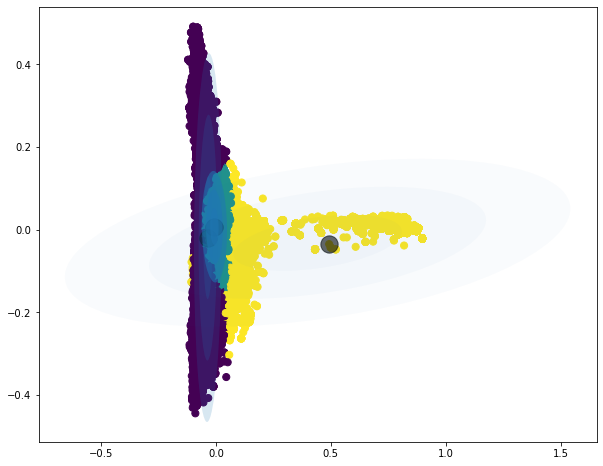

In [17]:
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)

Top Features

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [ ]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

In [ ]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)